In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"

In [ ]:
 !unzip -q dataset.zip
!unzip -q dataset/converted.zip
!unzip -q dataset/test9classes.zip

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Here I have used Alexnet architecture pre-trained on Imagenet Dataset

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        from torchvision import models
        # downloading pretrained model from torchvision
        alexnet = models.alexnet(pretrained=True)
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = alexnet.classifier
        self.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function

def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
with open('test9classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']
4050
4050


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 1000 # We use a small batch size here for training
batch_size_test = 100 #
batch_size_val = 100

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('converted/', val_files, val_classes, 
                         transforms=image_transform)
test_dataset = Hist('test9classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: DEB


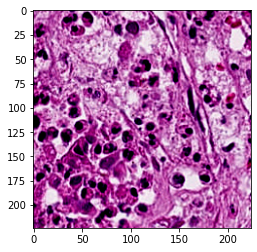

In [ ]:
# import library
import matplotlib.pyplot as plt
# Checking the data loader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# showing random image from dataloader
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 30
accuracy_test=[]

for i in range(5):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = AlexNet(9).to(device)
  learning_rate = 0.0005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("AlexNet9SGD.pth"):
        os.remove("AlexNet9SGD.pth")
      torch.save(model.state_dict(), 'AlexNet9SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = AlexNet(9).to(device)
  model.load_state_dict(torch.load('AlexNet9SGD.pth', map_location=device))
  model=model.to(device)
  
  l,a=test(model, device, test_loader)
  accuracy_test.append(a)
print(accuracy_test)

Experiment:  1


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

1


<ipython-input-6-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 1.7279

Test: Average loss: 0.9769, Accuracy: 3907/5400 (72.35%)

2


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.7711

Test: Average loss: 0.5484, Accuracy: 4414/5400 (81.74%)

3


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5198

Test: Average loss: 0.4256, Accuracy: 4637/5400 (85.87%)

4


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4253

Test: Average loss: 0.3651, Accuracy: 4740/5400 (87.78%)

5


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3731

Test: Average loss: 0.3240, Accuracy: 4804/5400 (88.96%)

6


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3414

Test: Average loss: 0.3035, Accuracy: 4842/5400 (89.67%)

7


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3174

Test: Average loss: 0.2790, Accuracy: 4893/5400 (90.61%)

8


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2975

Test: Average loss: 0.2631, Accuracy: 4917/5400 (91.06%)

9


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2819

Test: Average loss: 0.2539, Accuracy: 4948/5400 (91.63%)

10


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2677

Test: Average loss: 0.2419, Accuracy: 4967/5400 (91.98%)

11


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2601

Test: Average loss: 0.2325, Accuracy: 4990/5400 (92.41%)

12


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2495

Test: Average loss: 0.2308, Accuracy: 4982/5400 (92.26%)

13


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2397

Test: Average loss: 0.2190, Accuracy: 5012/5400 (92.81%)

14


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2256

Test: Average loss: 0.2107, Accuracy: 5031/5400 (93.17%)

15


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2236

Test: Average loss: 0.2042, Accuracy: 5037/5400 (93.28%)

16


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2176

Test: Average loss: 0.2034, Accuracy: 5028/5400 (93.11%)

17


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2108

Test: Average loss: 0.1964, Accuracy: 5043/5400 (93.39%)

18


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2035

Test: Average loss: 0.1915, Accuracy: 5056/5400 (93.63%)

19


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2023

Test: Average loss: 0.1875, Accuracy: 5067/5400 (93.83%)

20


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1952

Test: Average loss: 0.1841, Accuracy: 5069/5400 (93.87%)

21


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1861

Test: Average loss: 0.1838, Accuracy: 5083/5400 (94.13%)

22


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1811

Test: Average loss: 0.1781, Accuracy: 5078/5400 (94.04%)

23


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1825

Test: Average loss: 0.1726, Accuracy: 5093/5400 (94.31%)

24


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1761

Test: Average loss: 0.1717, Accuracy: 5100/5400 (94.44%)

25


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1751

Test: Average loss: 0.1696, Accuracy: 5102/5400 (94.48%)

26


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1679

Test: Average loss: 0.1668, Accuracy: 5099/5400 (94.43%)

27


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1653

Test: Average loss: 0.1650, Accuracy: 5104/5400 (94.52%)

28


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1641

Test: Average loss: 0.1627, Accuracy: 5114/5400 (94.70%)

29


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1603

Test: Average loss: 0.1595, Accuracy: 5120/5400 (94.81%)

30


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1544

Test: Average loss: 0.1575, Accuracy: 5115/5400 (94.72%)

Test: Average loss: 0.1653, Accuracy: 3829/4050 (94.54%)

Experiment:  2
1


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 1.7364

Test: Average loss: 1.0231, Accuracy: 3687/5400 (68.28%)

2


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.8063

Test: Average loss: 0.5513, Accuracy: 4446/5400 (82.33%)

3


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5243

Test: Average loss: 0.4173, Accuracy: 4621/5400 (85.57%)

4


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4301

Test: Average loss: 0.3594, Accuracy: 4734/5400 (87.67%)

5


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3788

Test: Average loss: 0.3218, Accuracy: 4819/5400 (89.24%)

6


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3476

Test: Average loss: 0.2965, Accuracy: 4853/5400 (89.87%)

7


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3179

Test: Average loss: 0.2832, Accuracy: 4882/5400 (90.41%)

8


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3063

Test: Average loss: 0.2638, Accuracy: 4920/5400 (91.11%)

9


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2893

Test: Average loss: 0.2499, Accuracy: 4939/5400 (91.46%)

10


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2713

Test: Average loss: 0.2424, Accuracy: 4966/5400 (91.96%)

11


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2623

Test: Average loss: 0.2307, Accuracy: 4979/5400 (92.20%)

12


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2519

Test: Average loss: 0.2244, Accuracy: 4999/5400 (92.57%)

13


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2432

Test: Average loss: 0.2153, Accuracy: 5014/5400 (92.85%)

14


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2329

Test: Average loss: 0.2096, Accuracy: 5013/5400 (92.83%)

15


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2246

Test: Average loss: 0.2050, Accuracy: 5026/5400 (93.07%)

16


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2192

Test: Average loss: 0.2008, Accuracy: 5028/5400 (93.11%)

17


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2086

Test: Average loss: 0.1956, Accuracy: 5045/5400 (93.43%)

18


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2058

Test: Average loss: 0.1906, Accuracy: 5054/5400 (93.59%)

19


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1986

Test: Average loss: 0.1876, Accuracy: 5060/5400 (93.70%)

20


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1973

Test: Average loss: 0.1845, Accuracy: 5065/5400 (93.80%)

21


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1930

Test: Average loss: 0.1798, Accuracy: 5073/5400 (93.94%)

22


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1872

Test: Average loss: 0.1768, Accuracy: 5082/5400 (94.11%)

23


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1853

Test: Average loss: 0.1740, Accuracy: 5094/5400 (94.33%)

24


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1784

Test: Average loss: 0.1712, Accuracy: 5088/5400 (94.22%)

25


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1760

Test: Average loss: 0.1697, Accuracy: 5094/5400 (94.33%)

26


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1709

Test: Average loss: 0.1683, Accuracy: 5091/5400 (94.28%)

27


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1638

Test: Average loss: 0.1645, Accuracy: 5108/5400 (94.59%)

28


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1633

Test: Average loss: 0.1598, Accuracy: 5117/5400 (94.76%)

29


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1588

Test: Average loss: 0.1616, Accuracy: 5111/5400 (94.65%)

30


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1581

Test: Average loss: 0.1562, Accuracy: 5122/5400 (94.85%)

Test: Average loss: 0.1644, Accuracy: 3836/4050 (94.72%)

Experiment:  3
1


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 1.7845

Test: Average loss: 1.0204, Accuracy: 3754/5400 (69.52%)

2


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.7895

Test: Average loss: 0.5614, Accuracy: 4386/5400 (81.22%)

3


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5252

Test: Average loss: 0.4217, Accuracy: 4628/5400 (85.70%)

4


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4290

Test: Average loss: 0.3605, Accuracy: 4760/5400 (88.15%)

5


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3796

Test: Average loss: 0.3229, Accuracy: 4815/5400 (89.17%)

6


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3405

Test: Average loss: 0.2978, Accuracy: 4869/5400 (90.17%)

7


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3172

Test: Average loss: 0.2775, Accuracy: 4909/5400 (90.91%)

8


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2987

Test: Average loss: 0.2665, Accuracy: 4935/5400 (91.39%)

9


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2834

Test: Average loss: 0.2524, Accuracy: 4952/5400 (91.70%)

10


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2691

Test: Average loss: 0.2439, Accuracy: 4952/5400 (91.70%)

11


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2621

Test: Average loss: 0.2314, Accuracy: 4979/5400 (92.20%)

12


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2495

Test: Average loss: 0.2239, Accuracy: 4994/5400 (92.48%)

13


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2362

Test: Average loss: 0.2197, Accuracy: 4996/5400 (92.52%)

14


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2297

Test: Average loss: 0.2125, Accuracy: 5010/5400 (92.78%)

15


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2248

Test: Average loss: 0.2065, Accuracy: 5028/5400 (93.11%)

16


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2160

Test: Average loss: 0.2028, Accuracy: 5022/5400 (93.00%)

17


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2107

Test: Average loss: 0.1984, Accuracy: 5037/5400 (93.28%)

18


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2022

Test: Average loss: 0.1939, Accuracy: 5041/5400 (93.35%)

19


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1984

Test: Average loss: 0.1872, Accuracy: 5054/5400 (93.59%)

20


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1915

Test: Average loss: 0.1857, Accuracy: 5062/5400 (93.74%)

21


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1892

Test: Average loss: 0.1819, Accuracy: 5062/5400 (93.74%)

22


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1845

Test: Average loss: 0.1807, Accuracy: 5068/5400 (93.85%)

23


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1793

Test: Average loss: 0.1786, Accuracy: 5069/5400 (93.87%)

24


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1755

Test: Average loss: 0.1750, Accuracy: 5082/5400 (94.11%)

25


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1720

Test: Average loss: 0.1709, Accuracy: 5090/5400 (94.26%)

26


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1667

Test: Average loss: 0.1689, Accuracy: 5088/5400 (94.22%)

27


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1627

Test: Average loss: 0.1668, Accuracy: 5087/5400 (94.20%)

28


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1621

Test: Average loss: 0.1646, Accuracy: 5097/5400 (94.39%)

29


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1563

Test: Average loss: 0.1645, Accuracy: 5096/5400 (94.37%)

30


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1571

Test: Average loss: 0.1666, Accuracy: 5085/5400 (94.17%)

Test: Average loss: 0.1691, Accuracy: 3822/4050 (94.37%)

Experiment:  4
1


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 1.8010

Test: Average loss: 1.0797, Accuracy: 3654/5400 (67.67%)

2


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.8618

Test: Average loss: 0.6167, Accuracy: 4204/5400 (77.85%)

3


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5800

Test: Average loss: 0.4540, Accuracy: 4565/5400 (84.54%)

4


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4614

Test: Average loss: 0.3840, Accuracy: 4716/5400 (87.33%)

5


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4020

Test: Average loss: 0.3436, Accuracy: 4781/5400 (88.54%)

6


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3666

Test: Average loss: 0.3134, Accuracy: 4820/5400 (89.26%)

7


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3440

Test: Average loss: 0.2922, Accuracy: 4875/5400 (90.28%)

8


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3220

Test: Average loss: 0.2757, Accuracy: 4900/5400 (90.74%)

9


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2972

Test: Average loss: 0.2614, Accuracy: 4919/5400 (91.09%)

10


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2823

Test: Average loss: 0.2513, Accuracy: 4947/5400 (91.61%)

11


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2718

Test: Average loss: 0.2440, Accuracy: 4956/5400 (91.78%)

12


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2616

Test: Average loss: 0.2344, Accuracy: 4971/5400 (92.06%)

13


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2517

Test: Average loss: 0.2235, Accuracy: 4997/5400 (92.54%)

14


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2413

Test: Average loss: 0.2164, Accuracy: 5017/5400 (92.91%)

15


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2336

Test: Average loss: 0.2150, Accuracy: 5018/5400 (92.93%)

16


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2264

Test: Average loss: 0.2035, Accuracy: 5035/5400 (93.24%)

17


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2197

Test: Average loss: 0.1973, Accuracy: 5041/5400 (93.35%)

18


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2096

Test: Average loss: 0.1918, Accuracy: 5047/5400 (93.46%)

19


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2072

Test: Average loss: 0.1924, Accuracy: 5053/5400 (93.57%)

20


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2043

Test: Average loss: 0.1870, Accuracy: 5060/5400 (93.70%)

21


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1901

Test: Average loss: 0.1824, Accuracy: 5067/5400 (93.83%)

22


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1904

Test: Average loss: 0.1802, Accuracy: 5078/5400 (94.04%)

23


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1879

Test: Average loss: 0.1743, Accuracy: 5085/5400 (94.17%)

24


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1827

Test: Average loss: 0.1733, Accuracy: 5087/5400 (94.20%)

25


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1786

Test: Average loss: 0.1723, Accuracy: 5092/5400 (94.30%)

26


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1686

Test: Average loss: 0.1673, Accuracy: 5099/5400 (94.43%)

27


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1704

Test: Average loss: 0.1636, Accuracy: 5094/5400 (94.33%)

28


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1635

Test: Average loss: 0.1602, Accuracy: 5109/5400 (94.61%)

29


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1611

Test: Average loss: 0.1591, Accuracy: 5103/5400 (94.50%)

30


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1619

Test: Average loss: 0.1575, Accuracy: 5118/5400 (94.78%)

Test: Average loss: 0.1696, Accuracy: 3828/4050 (94.52%)

Experiment:  5
1


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 1.8111

Test: Average loss: 1.0651, Accuracy: 3789/5400 (70.17%)

2


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.8397

Test: Average loss: 0.5808, Accuracy: 4390/5400 (81.30%)

3


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.5401

Test: Average loss: 0.4334, Accuracy: 4599/5400 (85.17%)

4


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.4388

Test: Average loss: 0.3687, Accuracy: 4717/5400 (87.35%)

5


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3822

Test: Average loss: 0.3328, Accuracy: 4796/5400 (88.81%)

6


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3440

Test: Average loss: 0.3026, Accuracy: 4861/5400 (90.02%)

7


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3218

Test: Average loss: 0.2796, Accuracy: 4898/5400 (90.70%)

8


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.3045

Test: Average loss: 0.2657, Accuracy: 4916/5400 (91.04%)

9


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2883

Test: Average loss: 0.2535, Accuracy: 4948/5400 (91.63%)

10


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2730

Test: Average loss: 0.2421, Accuracy: 4974/5400 (92.11%)

11


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2607

Test: Average loss: 0.2306, Accuracy: 5002/5400 (92.63%)

12


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2459

Test: Average loss: 0.2213, Accuracy: 5013/5400 (92.83%)

13


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2421

Test: Average loss: 0.2148, Accuracy: 5030/5400 (93.15%)

14


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2302

Test: Average loss: 0.2072, Accuracy: 5038/5400 (93.30%)

15


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2201

Test: Average loss: 0.1998, Accuracy: 5053/5400 (93.57%)

16


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2156

Test: Average loss: 0.1957, Accuracy: 5057/5400 (93.65%)

17


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2100

Test: Average loss: 0.1907, Accuracy: 5064/5400 (93.78%)

18


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.2035

Test: Average loss: 0.1857, Accuracy: 5080/5400 (94.07%)

19


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1988

Test: Average loss: 0.1826, Accuracy: 5084/5400 (94.15%)

20


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1894

Test: Average loss: 0.1798, Accuracy: 5080/5400 (94.07%)

21


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1879

Test: Average loss: 0.1760, Accuracy: 5093/5400 (94.31%)

22


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1869

Test: Average loss: 0.1712, Accuracy: 5098/5400 (94.41%)

23


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1799

Test: Average loss: 0.1728, Accuracy: 5102/5400 (94.48%)

24


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1715

Test: Average loss: 0.1679, Accuracy: 5099/5400 (94.43%)

25


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1708

Test: Average loss: 0.1635, Accuracy: 5118/5400 (94.78%)

26


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1662

Test: Average loss: 0.1618, Accuracy: 5123/5400 (94.87%)

27


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1635

Test: Average loss: 0.1619, Accuracy: 5118/5400 (94.78%)

28


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1554

Test: Average loss: 0.1583, Accuracy: 5118/5400 (94.78%)

29


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1554

Test: Average loss: 0.1546, Accuracy: 5132/5400 (95.04%)

30


  0%|          | 0/13 [00:00<?, ?it/s]

Train: Average loss: 0.1559

Test: Average loss: 0.1530, Accuracy: 5129/5400 (94.98%)

Test: Average loss: 0.1654, Accuracy: 3832/4050 (94.62%)

[94.54320987654322, 94.71604938271605, 94.37037037037037, 94.51851851851852, 94.61728395061728]


In [1]:
import numpy as np
acc=np.array([94.54320987654322, 94.71604938271605, 94.37037037037037, 94.51851851851852, 94.61728395061728])
print(np.mean(acc))
print(np.std(acc))

94.55308641975309
0.11432925336089188
